In [ ]:
import cv2
import numpy as np
import os
import math
from src.our_chessboard_detection import *
from matplotlib import pyplot as plt

dataDir = 'images' # Change this, according to your images' directory path

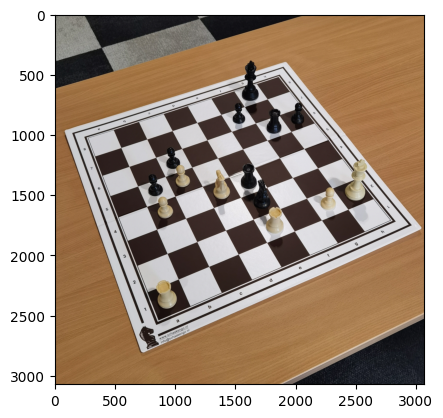

In [24]:
# Open image
image = cv2.imread(os.path.join(dataDir, 'G000_IMG062.jpg')) # Change this, according to your image's path
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2.imshow("Image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(rgb)

### applying different filters

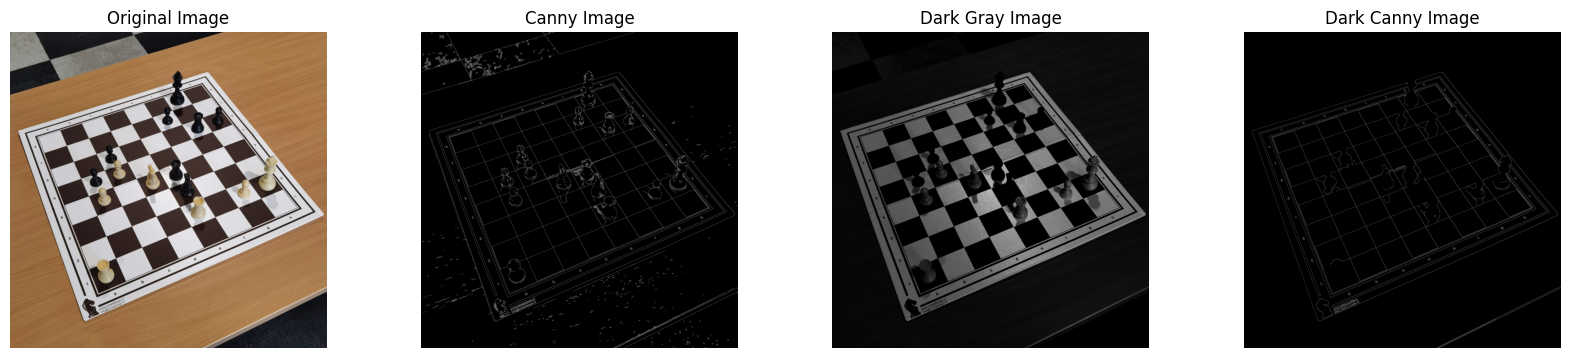

In [16]:
filtered_images = apply_filters(image, True)

### Detecting chessboard

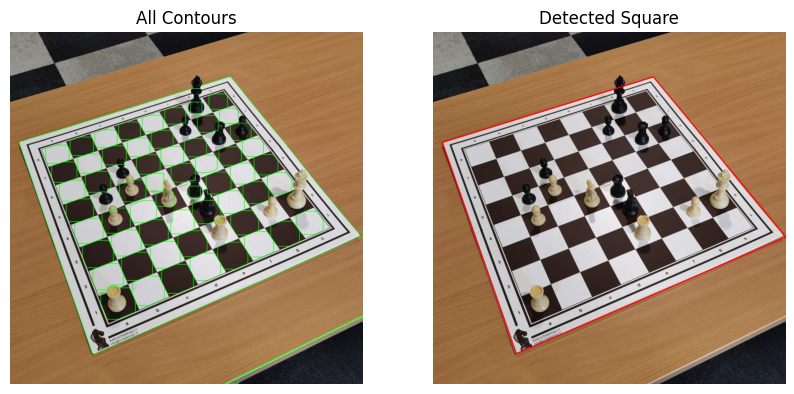

In [17]:
chess_contour = get_contours(filtered_images, show=True,  kernel_size=(25,25) ,  kernel_usage=True, iterations=4)

### rotate and warp

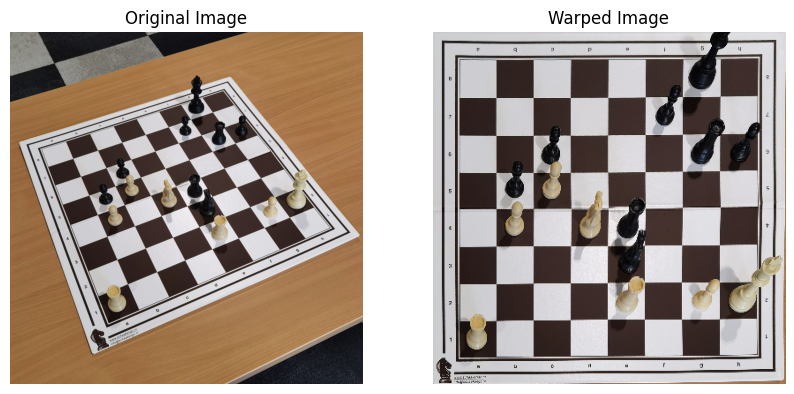

In [18]:
warped_image, M = rotate_and_crop(filtered_images, chess_contour[0][1], show=True)

In [19]:
cv2.imwrite('test.jpg', warped_image)

True

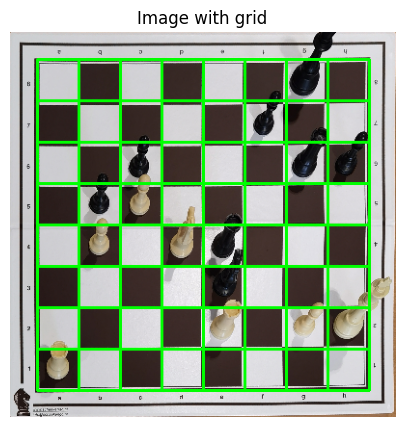

In [20]:
grid_image = chesboard_grids(warped_image, show = True)

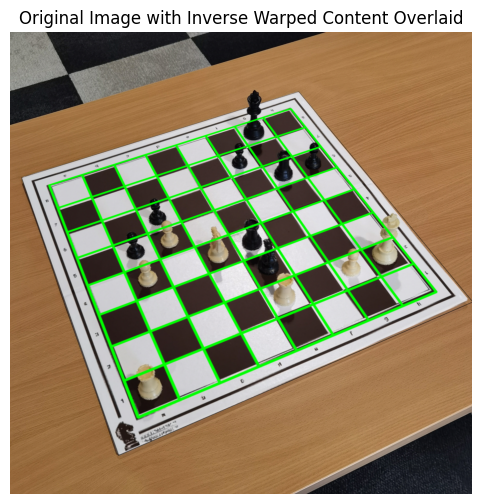

array([[[111, 119, 119],
        [116, 124, 124],
        [118, 126, 126],
        ...,
        [ 68, 116, 164],
        [ 68, 116, 164],
        [ 67, 115, 163]],

       [[112, 120, 120],
        [115, 123, 123],
        [116, 124, 124],
        ...,
        [ 69, 117, 165],
        [ 69, 117, 165],
        [ 69, 117, 165]],

       [[115, 123, 123],
        [117, 125, 125],
        [118, 126, 126],
        ...,
        [ 69, 117, 165],
        [ 69, 117, 165],
        [ 69, 117, 165]],

       ...,

       [[ 60, 104, 151],
        [ 59, 103, 150],
        [ 59, 103, 150],
        ...,
        [ 48,  39,  36],
        [ 47,  38,  35],
        [ 47,  38,  35]],

       [[ 58, 102, 149],
        [ 58, 102, 149],
        [ 58, 102, 149],
        ...,
        [ 47,  38,  35],
        [ 47,  38,  35],
        [ 48,  39,  36]],

       [[ 56, 100, 147],
        [ 56, 100, 147],
        [ 56, 100, 147],
        ...,
        [ 45,  36,  33],
        [ 45,  36,  33],
        [ 46,  37,  34]]

In [21]:
inverse_rotate_crop(grid_image, M, image, True)

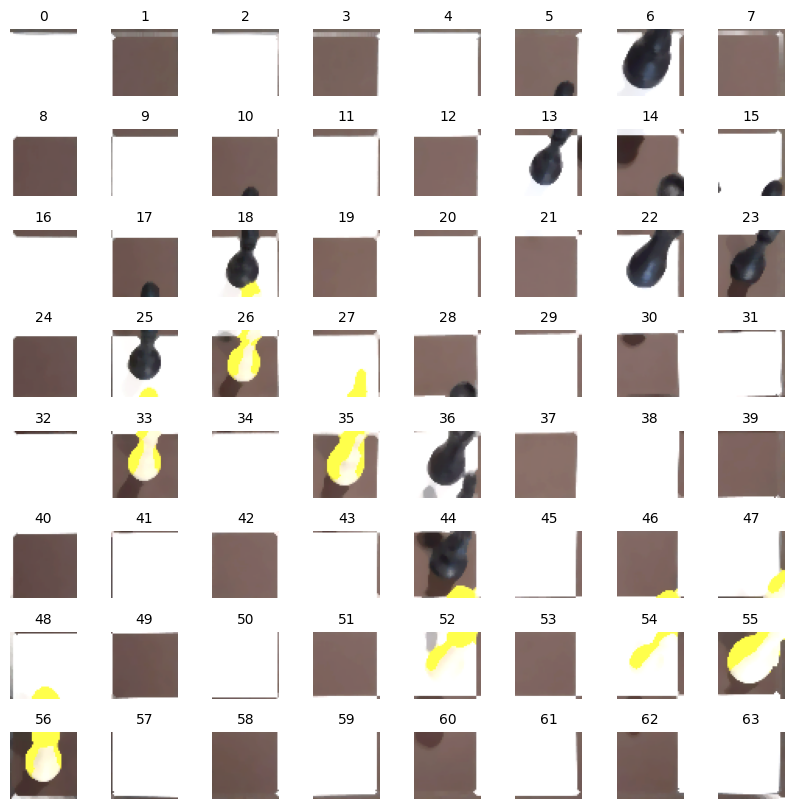

In [22]:
squares = display_chessboard_squares(warped_image)

In [ ]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def adjust_contrast(image, alpha=1.5, beta=0):
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def normalize_white_pieces(square_rgb):
    hsv = cv2.cvtColor(square_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    mask = (
        (h >= 15) & (h <= 45) &
        (s >= 50) & (s <= 200) &
        (v >= 100) & (v <= 240)
    )
    hsv[mask] = (30, 180, 200)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def display_chessboard_squares(warped, gamma=1.5):
    img_grid = warped.copy()
    squares = []

    for row in range(8):
        for col in range(8):
            x1 = margin + col * square_size
            y1 = margin + row * square_size
            x2 = x1 + square_size
            y2 = y1 + square_size

            square = warped[y1:y2, x1:x2]
            square_rgb = cv2.cvtColor(square, cv2.COLOR_BGR2RGB)
            image_light = adjust_gamma(square_rgb, gamma)
            image_norm = normalize_white_pieces(image_light)
            image_contrast = adjust_contrast(image_norm, alpha=1.3, beta=0)
            image_filtered = cv2.medianBlur(image_contrast, 5)
            squares.append(image_filtered)

    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(squares[i])
        ax.axis('off')
        ax.set_title(f"{i}", fontsize=10)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

    return squares

In [ ]:
squares = display_chessboard_squares(warped_image)

In [ ]:
def check_piece_at_center(square, black_piece=(45, 45, 45), white_piece=(255, 252, 94)):
    
    # Center of the square
    center_x = square.shape[1] // 2
    center_y = square.shape[0] // 2

    # Crop a small region around the center 3x3
    crop_size = 3 
    crop_x1 = max(center_x - crop_size // 2, 0)
    crop_y1 = max(center_y - crop_size // 2, 0)
    crop_x2 = min(center_x + crop_size // 2, square.shape[1])
    crop_y2 = min(center_y + crop_size // 2, square.shape[0])

    # Crop the center region
    cropped_region = square[crop_y1:crop_y2, crop_x1:crop_x2]

    # Calculate the average color of the center
    avg_color = np.mean(cropped_region, axis=(0, 1))

    # Compare the average color with the predefined values
    if np.allclose(avg_color, white_piece, atol=50):  # allow a tolerance for slight color variations
        return "WHITE"
    elif np.allclose(avg_color, black_piece, atol=35):
        return "BLACK"
    else:
        return "EMPTY"

In [ ]:
def process_chessboard(squares):
    # Initialize matrix for 8x8 board and counters for white and black pieces
    board_matrix = np.zeros((8, 8))
    white_count = 0
    black_count = 0

    for i in range(8):
        for j in range(8):
            square = squares[i * 8 + j]

            # Check the piece at the center of the square
            piece_type = check_piece_at_center(square)

            # If the piece is a WHITE or BLACK
            if piece_type == "WHITE" or piece_type == "BLACK":
                board_matrix[i, j] = 1

                # Count white and black pieces
                if piece_type == "WHITE":
                    white_count += 1
                elif piece_type == "BLACK":
                    black_count += 1

    # Print the board matrix
    print("Board Matrix (8x8):")
    print(board_matrix)

    # Print the counts of cream and black pieces
    print(f"White pieces: {white_count}")
    print(f"Black pieces: {black_count}")

In [ ]:
process_chessboard(squares)